# Predicting cold call success for car insurance
_Our objective in this notebook is to predict whether or not a person will sign up for car insurance over the phone, given information such as marital status, education, etc._

# Table of contents
1. [Background](#Background)
2. [Data ingestion](#Data-ingestion)
3. [Data preprocessing](#Data-preprocessing)
4. [Exploratory Data Analysis](#EDA)
5. [Model Training](#Model-Training)
6. [Testing the Model](#Testing-the-Model)
7. [Conclusion](#Conclusion)
8. [Credits](#Credits)

# Background

## Purpose
Cold calling has been a controversial business route for both companies and customers alike, and the growth of mobile phones across the globe means that reaching people over the phone has never been easier. [92% of all customer interactions happen over the phone](https://blog.thebrevetgroup.com/21-mind-blowing-sales-stats), meaning that cold calling is still very relevant today.  

Both companies and consumers dislike cold calling for two main reasons: cold calling takes a long amount of time and cold calling can have detrimental effects when done improperly.  

This article will detail one possible route to improving cold call efficiency by utilizing public callee data to pre-emptively predict if a call will be successful. 

## Introduction

In this notebook, I used a public dataset from Kaggle located [HERE](https://www.kaggle.com/kondla/carinsurance). Thanks to the Technical University of Munich and Kaggle for providing the data.  

The first step will be observing our data and understanding what we're dealing with. Second, we will "clean" the dataset, dropping empty values and scaling where needed. Third, we will balance our dataset to get reliable predictions for fraudulent and non-fraudulent transactions. Fourth, we will build and train a model to help us predict outcomes. 

This notebook contains various columns with categorical data. Let's do a quick rundown of the contents of the dataset. 

**Id** is a unique number given to each person called.  

**Age**, **Job**, **Marital Status**, and **Education**, etc. are all self-explanatory. 

There are some columns that are not detailed in the Kaggle page for this dataset. I've tried to use my best reasoning behind their meaning, but there may be some errors in my understanding. 

**CallStart** and **CallEnd** are used to calculate the duration of the call.  

**Outcome** is whether the call resulted in a sale or not. 

# Data ingestion

## Initial thoughts

This dataset requires a lot of modification in order to be able to accurately predict successes. This is because our prediction models use numerical data to train themselves. If these numbers are very different from one another, or they appear to be randomly occurring, the algorithms we train will have a tough time trying to gain any "insight" on how to predict.  

Keep in mind that for people, predicting the next number after 2, 4, 8, 16 is simple *because we can understand the pattern*. We see that the subsequent number is double the previous, and we use that *rule* to predict the following number.  

In machine learning, the computer uses algorithms to help it find the same rules we use. This is where the learning occurs. The machine would go through the data points and find a function, in this case y = 2^x, that it will use to predict the following number. Of course, the actual math and theory behind this is infinitely more complicated, but for our use case, this simple understanding is enough. 

Like the credit card model, there are a lot of null values for the 'Outcome' column, but not very many successes or failures. We will most likely have to restructure our dataset by dropping these null values to improve the accuracy of our models. This has the negative effect of also reducing the size of our dataset, but the accuracy of the model won't change too much compared to if we had left the null values alone. 

CallStart and CallEnd aren't very useful attributes on their own, but we can generate a new column, 'CallLength', to better reflect what we want. It seems really important to know the length of a sales call, especially the differences in length between a successful call and a failed one. This process is called feature engineering, which uses existing data to create new data that is more relevant to our use case.  

We will also have to numerically map a lot of the categorical data present in this file. Categorical data is anything that isn't a number. Since our machine learning models use numbers to find the prediction rules, we map the non-numerical data to numbers and use that to train the model. 


# Data preprocessing

The purpose of the data preprocessing stage is to minimize potential error in the model as much as possible. Generally, a model is only as good as the data passed into it, and the data preprocessing we do ensures that the model has as accurate a dataset as possible. While we cannot perfectly clean the dataset, we can at least follow some basics steps to ensure that our dataset has the best possible chance of generating a good model. 

First, let's check for null values in our dataset. Null values are empty, useless entries within our dataset that we don't need. If we skip removing null values, our model will be inaccurate as we create "connections" for useless values, rather than focusing all resources onto creating connections for useful values. 

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('carInsurance_train.csv')
print("Presence of any null values: " + str(df.isnull().values.any()))

Presence of any null values: True


We will be clearing out these null values before we can use this dataset. Let's take a peek at what our dataset looks like.

In [2]:
df.head()

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,13:45:20,13:46:30,0
1,2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,14:49:03,14:52:08,0
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,16:30:24,16:36:04,1
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,12:06:43,12:20:22,1
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,14:35:44,14:38:56,0


We've been given a testing and training dataset, but I like to merge the test and training set, and split them later for my own use. 

In [3]:
test_df = pd.read_csv("carInsurance_test.csv")
test_df.head()

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
0,4001,25,admin.,single,secondary,0,1,1,1,NaN,12,may,12,-1,0,NaN,17:17:42,17:18:06,NaN
1,4002,40,management,married,tertiary,0,0,1,1,cellular,24,jul,1,-1,0,NaN,09:13:44,09:14:37,NaN
2,4003,44,management,single,tertiary,0,-1313,1,1,cellular,15,may,10,-1,0,NaN,15:24:07,15:25:51,NaN
3,4004,27,services,single,secondary,0,6279,1,0,cellular,9,nov,1,-1,0,NaN,09:43:44,09:48:01,NaN
4,4005,53,technician,married,secondary,0,7984,1,0,cellular,2,feb,1,-1,0,NaN,16:31:51,16:34:22,NaN


In [4]:
print("Presence of any null values: " + str(test_df.isnull().values.any()))

Presence of any null values: True


We will have to clear out these null values before we can do any operations with this data. First, let's merge the datasets together, and then we can clean out the null values from our data. 

In [5]:
df = pd.concat([df, test_df], keys=('train','test'))
np.where(pd.isnull(df))

(array([   0,    1,    1, ..., 4998, 4999, 4999], dtype=int64),
 array([15,  9, 15, ..., 18, 15, 18], dtype=int64))

Judging from the dataset previews above, most of the NaNs appear to be coming from Communication, Outcome, and CarInsurance. Let's drop Communication and CarInsurance, and fill NaN Outcome values with 0. I would drop these rows entirely normally, but since we have very few data points already, it's better to fill them with 'unsuccessful' values rather than have 100 valid data points. 

In [6]:
df.pop('Communication')
df.pop('CarInsurance')
df.fillna('failure')

Id  Age            Job   Marital  Education  Default  Balance  \
train 0       1   32     management    single   tertiary        0     1218   
      1       2   32    blue-collar   married    primary        0     1156   
      2       3   29     management    single   tertiary        0      637   
      3       4   25        student    single    primary        0      373   
      4       5   30     management   married   tertiary        0     2694   
      5       6   32     technician    single   tertiary        0     1625   
      6       7   37         admin.    single   tertiary        0     1000   
      7       8   35     management  divorced   tertiary        0      538   
      8       9   30         admin.   married  secondary        0      187   
      9      10   30    blue-collar   married  secondary        0        3   
      10     11   27       services    single  secondary        0        0   
      11     12   53    blue-collar   married    primary        1     -462   
      12     13   44     technician   married  secondary        0     2776   
      13     14   38  self-employed  divorced  secondary        0     2674   
      14     15   25       services    single    failure        0     2022   
      15     16   61     management    single   tertiary        0        2   
      16     17   34         admin.    single  secondary        0       69   
      17     18   46     management   married   tertiary        0     7331   
      18     19   49    blue-collar   married  secondary        0     2039   
      19     20   50    blue-collar   married    primary        0       82   
      20     21   57    blue-collar   married  secondary        0      773   
      21     22   80        retired   married  secondary        0     8304   
      22     23   31     management    single   tertiary        0        0   
      23     24   63        retired   married  secondary        0     2896   
      24     25   60     technician   married  secondary        0      824   
      25     26   29     management   married   tertiary        0      900   
      26     27   54     management   married    primary        0     3859   
      27     28   45        failure  divorced    failure        0        0   
      28     29   34       services   married  secondary        0      -62   
      29     30   42    blue-collar   married    primary        0      832   
...         ...  ...            ...       ...        ...      ...      ...   
test  970  4971   56        retired   married    primary        0      340   
      971  4972   38     unemployed   married    primary        0      890   
      972  4973   62      housemaid   married    failure        0     2021   
      973  4974   83      housemaid  divorced    primary        0     5944   
      974  4975   33        student    single   tertiary        0      882   
      975  4976   50   entrepreneur   married  secondary        0       78   
      976  4977   53   entrepreneur   married  secondary        0      230   
      977  4978   28     management    single   tertiary        0     3285   
      978  4979   30         admin.  divorced  secondary        0      377   
      979  4980   51         admin.    single  secondary        0      726   
      980  4981   55     technician  divorced  secondary        0      184   
      981  4982   53     technician   married  secondary        0     9146   
      982  4983   31       services    single  secondary        0     -475   
      983  4984   40    blue-collar   married    primary        0      254   
      984  4985   35    blue-collar   married    failure        0      568   
      985  4986   25        student    single  secondary        0     2975   
      986  4987   53        retired   married  secondary        0      357   
      987  4988   33     technician   married   tertiary        0        0   
      988  4989   41    blue-collar    single    primary        0     -206   
      989  4990   37       services

Let's also pop Id as well. We can convert the CallStart and CallEnd data columns to DateTime format and create a new column called CallLength to better represent our data. Then, we can begin encoding our categorical data to numerical values. 

In [7]:
df.pop("Id")

col_list = df.columns.values.tolist()
for column in col_list:
    df[column] = df[column].fillna(value = 'failure')
    if column == 'CallStart' or column == 'CallEnd':
        df[column] = pd.to_datetime(df[column])
df.head()

Age          Job  Marital Education  Default  Balance  HHInsurance  \
train 0   32   management   single  tertiary        0     1218            1   
      1   32  blue-collar  married   primary        0     1156            1   
      2   29   management   single  tertiary        0      637            1   
      3   25      student   single   primary        0      373            1   
      4   30   management  married  tertiary        0     2694            0   

         CarLoan  LastContactDay LastContactMonth  NoOfContacts  DaysPassed  \
train 0        0              28              jan             2          -1   
      1        0              26              may             5          -1   
      2        0               3              jun             1         119   
      3        0              11              may             2          -1   
      4        0               3              jun             1          -1   

         PrevAttempts  Outcome           CallStart             CallEnd  
train 0             0  failure 2019-07-12 13:45:20 2019-07-12 13:46:30  
      1             0  failure 2019-07-12 14:49:03 2019-07-12 14:52:08  
      2             1  failure 2019-07-12 16:30:24 2019-07-12 16:36:04  
      3             0  failure 2019-07-12 12:06:43 2019-07-12 12:20:22  
      4             0  failure 2019-07-12 14:35:44 2019-07-12 14:38:56

Now, let's begin encoding our categorical data by using LabelEncoder.

In [8]:
from sklearn.preprocessing import LabelEncoder

col_list.remove('CallStart')
col_list.remove('CallEnd')

for column in col_list:
    encoder = LabelEncoder()
    encoder.fit(df[column])
    df[column] = encoder.transform(df[column])
    
df['CallLength'] = (df['CallEnd'] - df['CallStart'])/np.timedelta64(1, 'm').astype(float)

In [9]:
df.head()

Age  Job  Marital  Education  Default  Balance  HHInsurance  CarLoan  \
train 0   14    5        2          3        0     1250            1        0   
      1   14    1        1          1        0     1211            1        0   
      2   11    5        2          3        0      846            1        0   
      3    7    9        2          1        0      614            1        0   
      4   12    5        1          3        0     1791            0        0   

         LastContactDay  LastContactMonth  NoOfContacts  DaysPassed  \
train 0              27                 4             1           0   
      1              25                 8             4           0   
      2               2                 6             0          86   
      3              10                 8             1           0   
      4               2                 6             0           0   

         PrevAttempts  Outcome           CallStart             CallEnd  \
train 0             0        0 2019-07-12 13:45:20 2019-07-12 13:46:30   
      1             0        0 2019-07-12 14:49:03 2019-07-12 14:52:08   
      2             1        0 2019-07-12 16:30:24 2019-07-12 16:36:04   
      3             0        0 2019-07-12 12:06:43 2019-07-12 12:20:22   
      4             0        0 2019-07-12 14:35:44 2019-07-12 14:38:56   

        CallLength  
train 0   00:01:10  
      1   00:03:05  
      2   00:05:40  
      3   00:13:39  
      4   00:03:12

We now pop columns that aren't useful to us anymore, and we prepare to scale the data using sklearn's MinMaxScaler(). We scale values to be between 0 and 1 due to our model using numbers to again find the rules for predicting outcomes. Let's say we had one column called Outcome that was either 0 or 1, and another column called Income that went from 20,000 to 500,000.  

If we had to use both the Income and Outcome columns, our model would be training on values between 0 and 1 and another set of values that are significantly larger. This difference in number size causes the importance of the Outcome column to be dramatically reduced, even if we wanted both columns to have the same importance in our model. Always keep in mind that the computer only sees numbers. If we don't tell the computer that all of the columns are equally important by scaling numbers, the model will have skewed importances between the different features. 

To avoid this problem, we scale all numbers to be between 0 and 1, so that all values will have the same importance during the model training phase. 

In [10]:
df.pop('CallStart')
df.pop('CallEnd')
df.pop('LastContactMonth')
df.pop('LastContactDay')

train  0      27
       1      25
       2       2
       3      10
       4       2
       5      21
       6      16
       7      11
       8      17
       9      11
       10      0
       11     28
       12     26
       13     18
       14     28
       15     11
       16      5
       17     10
       18      5
       19      4
       20     17
       21      7
       22     20
       23      0
       24      8
       25     16
       26     19
       27     20
       28     15
       29     19
              ..
test   970    20
       971     4
       972    25
       973    29
       974     5
       975     3
       976     3
       977     8
       978     3
       979    26
       980    12
       981    12
       982    11
       983     6
       984    13
       985     1
       986    17
       987    29
       988    19
       989    21
       990     0
       991    13
       992     6
       993     0
       994    16
       995    14
       996     5
       997    

In [11]:
from sklearn.preprocessing import MinMaxScaler

col_list = df.columns.values.tolist()
scaler = MinMaxScaler(feature_range=(0,1))

for col in col_list:
    scaler = MinMaxScaler(feature_range=(0,1))
    df[col] = (scaler.fit_transform(df[col].values.reshape(-1, 1))).astype(float)

In [12]:
df.head()

Age       Job  Marital  Education  Default   Balance  \
train 0  0.202899  0.454545      1.0   1.000000      0.0  0.501002   
      1  0.202899  0.090909      0.5   0.333333      0.0  0.485371   
      2  0.159420  0.454545      1.0   1.000000      0.0  0.339078   
      3  0.101449  0.818182      1.0   0.333333      0.0  0.246092   
      4  0.173913  0.454545      0.5   1.000000      0.0  0.717836   

         HHInsurance  CarLoan  NoOfContacts  DaysPassed  PrevAttempts  \
train 0          1.0      0.0      0.029412    0.000000      0.000000   
      1          1.0      0.0      0.117647    0.000000      0.000000   
      2          1.0      0.0      0.000000    0.238227      0.047619   
      3          1.0      0.0      0.029412    0.000000      0.000000   
      4          0.0      0.0      0.000000    0.000000      0.000000   

         Outcome  CallLength  
train 0      0.0    0.020012  
      1      0.0    0.055419  
      2      0.0    0.103140  
      3      0.0    0.250616  
      4      0.0    0.057574

In [13]:
print("Presence of any null values: " + str(df.isnull().values.any()))

Presence of any null values: False


Now that we've cleaned out our dataset, we can begin analyzing some components to observe which features we can exploit to suit our model needs. 

# EDA

The purpose of Exploratory Data Analysis is to enhance our understanding of trends in the dataset without involving complicated machine learning models. Oftentimes, we can see obvious traits using graphs and charts just from plotting columns of the dataset against each other.

We've completed the necessary preprocessing steps, so let's create a correlation map to see the relations between different features.  

A correlation map (or correlation matrix) is a visual tool that illustrates the relationship between different columns of the dataset. The matrix will be lighter when the columns represented move in the same direction together, and it will be darker when one column decreases while the other increases. Strong spots of light and dark spots in our correlation matrix tell us about the future reliabilty of the model. 

Let's plot the correlation heatmap of this dataset.

In [14]:
import seaborn as sns

corr = df.corr()
sns.heatmap(corr)

From this map, we can see that there are some features we can use to get better classification results. DaysPassed has positive correlation with cold call success, and PrevAttempts is also positively correlated with successes. However, beyond these few columns there is very little else we can use. Regardless, let's make a bar graph of the amount of failures and successes. 

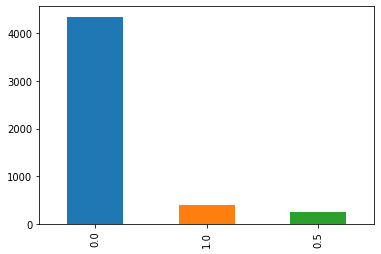

In [15]:
pd.value_counts(df['Outcome']).plot.bar()

Like the credit card model, our distributions for the outcome are very skewed toward failure. We will most likely need to trim this dataset to get better prediction results. Let's apply what we learned from the credit card model to see what is going on in this dataset. 

In [16]:
fail_df = df[df['Outcome'] == 0]
success_df = df[df['Outcome'] >= 0.5]

print("Number of failures: " + str(len(fail_df.index)))
print("Number of successes: " + str(len(success_df.index)))

Number of failures: 4347
Number of successes: 653


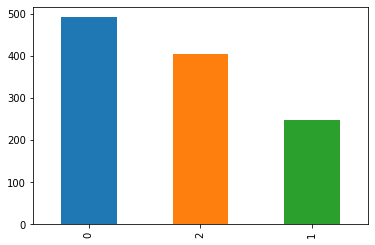

In [17]:
from sklearn.utils import shuffle 

fail_df = shuffle(df.loc[df['Outcome'] == 0])[:492]
df = pd.concat([fail_df, shuffle(success_df)])

encoder = LabelEncoder()
df['Outcome'] = encoder.fit_transform(df['Outcome'])
pd.value_counts(df['Outcome']).plot.bar()


This distribution is much better for our model, at the cost of sacrificing much of our data. Hopefully, this model should be better. If not, we can always try with the original dataset as well. Since we're finished with our analysis, let's begin training the model. 

# Model Training

In this section, we will be creating and training our model for predicting whether a cold call is successful, unsuccessful, or other. Since there are multiple algorithms we can use to build our model, we will compare the accuracy scores after testing and pick the most accurate algorithm.

Begin by creating testing, training, and validation sets. 

In [18]:
from sklearn.model_selection import train_test_split

training,test = train_test_split(df, train_size = 0.7, test_size = 0.3, shuffle=True)
training, valid = train_test_split(training, train_size = 0.7, test_size =0.3, shuffle=True) 

training_label = training.pop('Outcome')
test_label = test.pop('Outcome')
valid_label = valid.pop('Outcome')

Now, we instantiate the different algorithms we will use for classification. Then, we train them and check what the accuracy is.

In [19]:
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model imporbt LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

xgb = XGBClassifier()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
nbc = GaussianNB()
LR = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
SVM = SVC(kernel='rbf', C=1,gamma='auto')
knn = KNeighborsClassifier(n_neighbors=3)

From this list, we are using XGBoost, DecisionTree, RandomForest, Naive Bayes, LogisticRegressoin, SVC, and KNeighborsClassifier to perform our predictions. We will then see which algorithm produces the highest accuracy and select it as our algorithm of choice for future use. We also want to partition our dataset into training, testing, and validation, so let's add a method for that ability. 

Let's perform the splitting of our data into test, train, validation using train_test_split.  

Our testing will take three phases: testing, training, and validation. Training is first, and it's where our model generates "intuition" about how to approach fraudulent and not fraudulent transactions. It is similar to a student studying and developing knowledge about a topic before an exam.  

The testing phase is where we see how the model performs against data where we know the outcome. This would be the exam if we continue the analogy from before. The algorithms will perform differently, similar to how students will score differently on the exam. From this phase, we generate an accuracy score to compare the different algorithms.  

The validation testing is how we check that the model isn't overfitting to our specific dataset. Overfitting is when the model starts to develop an intuition that is too specific to the training set. Overfitting is a problem because our model is no longer flexible. It may work on the initial set, but subsequent uses will cause our model to fail. Continuing the exam analogy, the validation testing phase is like another version of the exam with different questions. If a student happened to cheat on the first exam by knowing the questions, the second exam will give a better representation of performance.  

Note that verification doesn't completely disprove or prove overfitting, but the testing does give insight about it. 

In [20]:
# train the models
xgb.fit(training, training_label)
dtc.fit(training, training_label)
rfc.fit(training, training_label)
nbc.fit(training, training_label)
LR.fit(training, training_label)
SVM.fit(training, training_label)
knn.fit(training, training_label)

c:\users\tgmat\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

The accuracies for the different algorithms are shown below, sorted by algorithm name and then its decimal accuracy:

In [21]:
# try and predict an outcome from the test set
xgb_predict = xgb.predict(test)
dtc_predict = dtc.predict(test)
rfc_predict = rfc.predict(test)
nbc_predict = nbc.predict(test)
LR_predict = LR.predict(test)
SVM_predict = SVM.predict(test)
knn_predict = knn.predict(test)

#get accuracy score from models
from sklearn.metrics import accuracy_score

accuracy = dict()
accuracy['XGBoost'] = accuracy_score(test_label, xgb_predict)
accuracy['Naive_bayes'] = accuracy_score(test_label, nbc_predict)
accuracy['DecisionTree'] = accuracy_score(test_label, dtc_predict)
accuracy['RandomForest'] = accuracy_score(test_label,rfc_predict)
accuracy['support_vector_Machines'] = accuracy_score(test_label,SVM_predict)
accuracy['Linear Regression'] = accuracy_score(test_label,LR_predict)
accuracy['KNN'] = accuracy_score(test_label,knn_predict)

accuracy

{'XGBoost': 0.8197674418604651,
 'Naive_bayes': 0.4563953488372093,
 'DecisionTree': 0.7558139534883721,
 'RandomForest': 0.7761627906976745,
 'support_vector_Machines': 0.6947674418604651,
 'Linear Regression': 0.7267441860465116,
 'KNN': 0.6656976744186046}

These are okay prediction values, perhaps we can do better with more tuning. Let's try the validation testing to see what our predictions look like. Keep in mind that the Outcome variable we are trying to predict was composed of mostly null values, meaning that we would need more relevant data in order to create a better model. 

# Testing the Model

In [22]:
# perform validation testing for dataset
xgb_predict = xgb.predict(valid)
dtc_predict = dtc.predict(valid)
rfc_predict = rfc.predict(valid)
nbc_predict = nbc.predict(valid)
LR_predict = LR.predict(valid)
SVM_predict = SVM.predict(valid)
knn_predict = knn.predict(valid)

accuracy['XGBoost'] = accuracy_score(valid_label, xgb_predict) 
accuracy['Naive_bayes'] = accuracy_score(valid_label, nbc_predict)
accuracy['DecisionTree'] = accuracy_score(valid_label, dtc_predict)
accuracy['RandomForest'] = accuracy_score(valid_label,rfc_predict)
accuracy['support_vector_Machines'] = accuracy_score(valid_label,SVM_predict)
accuracy['Linear Regression'] = accuracy_score(valid_label,LR_predict)
accuracy['KNN'] = accuracy_score(valid_label,knn_predict)

accuracy

{'XGBoost': 0.7717842323651453,
 'Naive_bayes': 0.42738589211618255,
 'DecisionTree': 0.7302904564315352,
 'RandomForest': 0.7261410788381742,
 'support_vector_Machines': 0.6473029045643154,
 'Linear Regression': 0.7012448132780082,
 'KNN': 0.6182572614107884}

For the validation set, it seems XGBoost is performing the best, with an 77% accuracy score. Let's select it as the best performing model for now, and we can tune our model better to see if we can improve the accuracy score.  

In [23]:
max_accuracy = max(accuracy,key=accuracy.get)
max_accuracy

'XGBoost'

# Conclusion

During this notebook, we built a model that could accurately predict whether or not a cold call was successful, given data about the callee such as age, marital status, and education.  

Even though the accuracy of our model wasn't superb, keep in mind that we were given a very empty dataset. While there were many data points, the tiny amount of relevant information in the Outcome column meant that our model had very little actual data to train with. Even with this poor quality data, our model still achieved 77% accuacy with the XGBoost algorithm.  

For real-world use cases, a company could save a large amount of money avoiding calls that have a low chance of success simply by inputting some public information about the callee into our model. The consumer, on the other hand, will also deal with fewer irrelavant calls and will receive calls more related to what they actually need. In both cases, using machine learning to predict cold call success leads to beneficial outcomes for everyone involved.  

If you want to make the most of your company's data and time, Cocolevio's own 5411 product can help you build models that can make your business process as efficient as possible. 

# Credits

Thanks to the Kaggle community for helping me understand many of the concepts that I used during this analysis. 